> The notebook version of this post can be downloaded [here](https://github.com/jtrive84/jtrive84.github.io/blob/master/posts/practical-nlp-for-risk-modeling-part-1/practical-nlp-for-risk-modeling-part-1.ipynb).

Modern NLP workflows increasingly rely on pretrained transformer models such as BERT and its variants. These models are trained on massive text datasets to learn general purpose language representations that can be reused across a wide range of downstream tasks, including classification, information extraction, and document triage.

In an insurance setting, text classification problems show up frequently. Claim descriptions, underwriting notes, and risk control reports all contain unstructured text that often needs to be categorized, prioritized, or routed. Pretrained language models offer a practical way to extract meaningful signal from text without building task-specific representations from scratch.

When applying a pretrained model to a text classification problem, there are two common approaches: The first uses the pretrained model strictly as a feature extractor. The language model is treated as a frozen encoder that converts raw text into dense, fixed-length vector representations. These vectors are then passed into a traditional machine learning model for classification. The language model itself is never updated; it simply provides high-quality semantic features that can be plugged into an existing ML pipeline.

The second approach is end-to-end fine-tuning. A small classification head is attached directly to the pretrained model, and the entire network is trained jointly on a given task. During training, the model adjusts the classification layer as well as the internal language representations to better align with the target labels. This often yields higher accuracy, but comes at the cost of increased computational requirements and greater sensitivity to hyperparameters.

This post is the first in a four-part series that provides an end-to-end guide to applying modern transformer models for text classification in real-world data science workflows. Our focus will be on predicting the EF Scale for US tornado events based on event narratives captured in the NOAA Severe Weather Events Database,
which is a publicly available resource maintained by the National Centers for Environmental Information (NCEI) that documents significant weather events across the United States. Throughout the series, we'll work through four complementary themes:

- **Part I: Using Pretrained Transformers as Embedding Generators**
Introduces how to convert raw text into dense numeric embeddings using DistilBERT and use those embeddings as inputs to a classical machine learning model, establishing a simple baseline for text classification.

- **Part II: Fine-Tuning Transformers for Domain-Specific Text Classification**
Walks through training a transformer end-to-end on labeled text, explaining what changes compared to feature extraction, when fine-tuning is worth the cost, and how to structure training against the NOAA tornado event dataset. 

- **Part III: Evaluating Compressed vs Full Text**
Compares model performance when using full text versus compressed representations to assess trade-offs between accuracy and operational complexity.

- **Part IV: Interpretation and Calibration**
Focuses on making NLP models usable in production by covering probability calibration, threshold selection, error analysis, and interpretability techniques.

<br>

### **1. Pre-Processing**

The text descriptions are sourced from the the [NOAA Severe Weather Events Database](https://www.ncei.noaa.gov/stormevents/ftp.jsp). It contains detailed records on hazards such as tornadoes, hail, floods, hurricanes and winter storms. Each entry provides structured data and narrative descriptions. Each file contains two columns with text descriptions of significant weather events:

* **EVENT_NARRATIVE** describes the specific, individual event. For example, if there is a tornado in one county, the EVENT NARRATIVE contains details about that tornado (its path, damage, casualties, and circumstances).

* **EPISODE_NARRATIVE** describes the broader weather episode that groups multiple related events. For instance, if a line of severe thunderstorms produced several tornadoes and hail reports across multiple counties, the EPISODE_NARRATIVE provides the larger context of the storm system, while each tornado or hail report has its own EVENT NARRATIVE.

Think of EPISODE NARRATIVE as the big picture story of the weather system and EVENT NARRATIVE as the details of each individual occurrence. We will focus on EVENT_NARRATIVE for our analysis, but a follow-up analysis will assess whether EPISODE_NARRATIVE combined with EVENT_NARRATIVE offers improvement vs. EVENT_NARRATIVE alone.

The dataset is filtered to retain events from 2008 to present and records with EVENT_TYPE = 'Tornado'. We also drop records having TOR_F_SCALE "EFU", "EF0", "EF1","F0", "F1". 

Since our goal is to train a classifier that can distinguish between low severity (EF2) and high severity (EF3, EF4 and EF5) events based on the event narrative, a `CLASS` column is created and used as the target for the downstream classifier. `CLASS` takes on the value 0 for EF2 events and 1 for EF3, EF4 and EF5 events. 

To ensure the code provided is this series is reproducible into the future, it is strongly encouraged that a new virtual environment be created with the following dependencies:

```
# requirements.txt
numpy==1.26.4
pandas==2.2.1
scikit-learn==1.4.2
scipy==1.12.0
torch==2.4.1

# Hugging Face stack (Trainer-capable)
transformers==5.1.0
accelerate==1.3.0
datasets==2.18.0
evaluate==0.4.1

# Must match Transformers v5 requirements
tokenizers
huggingface-hub

# Utilities
tqdm==4.66.2
pyarrow==15.0.2
sentencepiece==0.2.0

# Additional
matplotlib==3.8.3
wordcloud==1.9.6
bs4 
requests 
contextily
geopandas
```

<br>

These can be installed directly from GitHub by executing the next cell:

In [ ]:
!python -m pip install -r https://gist.githubusercontent.com/jtrive84/e313afbf2def24687e3c3247aa836fe9/raw/f2493005d291920dc1fcfd54274b9dfa42004ebe/requirements.txt


<br>

NOAA's Storm Events Database can be pulled directly over HTTP, so we don't need use a special API client. The next cell programmatically discovers the latest file for each year and reads each into a single DataFrame. We first check whether *"noaa-events-2008-2025.parquet"* exists in the current working directory. If not, the files are downloaded and saved locally. Subsequent executions of the next cell will read your local file instead of unnecessarily burdening NOAA's file server:

In [2]:

import os
import pandas as pd
import requests
from bs4 import BeautifulSoup

base_url = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/"


def get_latest_details_file(year):
    """
    Return the filename of the latest details file for the given year.
    Sample filename: StormEvents_details-ftp_v1.0_d2022_c20250721.csv.gz
    """
    html = requests.get(base_url).text
    soup = BeautifulSoup(html, "html.parser")
    candidates = [
        a["href"]
        for a in soup.find_all("a", href=True)
        if f"StormEvents_details-ftp_v1.0_d{year}" in a["href"]
    ]

    return sorted(candidates)[-1]


# Check if dataset exists locally prior to hitting NOAA servers.
if not os.path.exists("noaa-events-2008-2025.parquet"):
    
    print("Fetching latest filenames from NOAA servers...")
    # Get latest filenames for years 2008-2025.
    latest_filenames = [get_latest_details_file(year) for year in range(2008, 2026)]

    # Load each file into a DataFrame and concatenate.
    dfall = pd.concat(
        [pd.read_csv(f"{base_url + fname}", compression="gzip") for fname in latest_filenames],
        ignore_index=True,
    )
else:
    print("Loading dataset locally...")
    dfall = pd.read_parquet("noaa-events-2008-2025.parquet")

print(f"Total records loaded: {dfall.shape[0]:,}")
dfall.head()



Fetching latest filenames from NOAA servers...
Total records loaded: 1,158,836


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,200802,22,1300,200802,22,2200,14216,79884,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A noreaster moved up the coast southeast of Ca...,NaN,CSV
1,200804,1,352,200804,1,352,15549,88334,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Strong southwest flow behind a warm front allo...,An amateur radio operator recorded a wind gust...,CSV
2,200803,1,0,200803,1,1320,14773,83820,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure tracked from the Great Lakes acro...,NaN,CSV
3,200801,14,500,200801,14,1700,13559,75727,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure moved up the Atlantic coast and s...,NaN,CSV
4,200812,19,1353,200812,21,200,25148,146588,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An intensifying coastal low spread heavy snow ...,Six to eight inches of snow fell across easter...,CSV


In [3]:

import warnings

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import torch

np.set_printoptions(suppress=True, precision=5, linewidth=1000)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option("display.precision", 5)
warnings.filterwarnings("ignore")


# Event files by year available @ https://www.ncei.noaa.gov/stormevents/ftp.jsp.
# events_path = "C:\\Users\\jtriv\\repos\\blog-posts-in-progress\\practical-nlp-for-risk-modeling-part-2\\noaa-events-2008-2025.parquet"
# dfall = pd.read_parquet(events_path)

# Filter for tornadoes from 2008 onward with significant damage ratings.
df = (
    dfall[
        (dfall.YEAR >= 2008) & 
        (dfall.EVENT_TYPE == "Tornado") & 
        (~dfall.TOR_F_SCALE.isin(["EFU", "EF0", "EF1" ,"F0", "F1"]))
    ]
    .dropna(subset=["EVENT_NARRATIVE"])
    .drop_duplicates(subset=["EVENT_NARRATIVE"])
    .reset_index(drop=True)
)

# Strip whitespace from EVENT_NARRATIVE.
df["EVENT_NARRATIVE"] = df["EVENT_NARRATIVE"].str.replace(r"\s+", " ", regex=True).str.strip()

# Create target class based on TOR_F_SCALE.
df["CLASS"] = np.where(df.TOR_F_SCALE.isin(["EF2"]), 0, 1)

print(f"Total records after filtering: {df.shape[0]:,}")

df.head()

Total records after filtering: 3,261


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,CLASS
0,200805,1,1759,200805,1,1816,18091,105611,IOWA,19,2008,May,Tornado,C,167,SIOUX,FSD,01-MAY-08 17:59:00,CST-6,01-MAY-08 18:16:00,0,0,0,0,0.50M,0.00K,NWS Storm Survey,NaN,NaN,NaN,NaN,EF2,8.89,400.0,FSD,IA,119.0,LYON,4.0,S,ROCK VLY,6.0,NW,ROCK VLY,43.1421,-96.3000,43.2573,-96.3787,Thunderstorms produced 5 confirmed tornadoes o...,"A tornado damaged numerous trees, including la...",CSV,0
1,200802,6,21,200802,6,25,13933,80215,KENTUCKY,21,2008,February,Tornado,C,93,HARDIN,LMK,06-FEB-08 00:21:00,EST-5,06-FEB-08 00:25:00,0,0,0,0,3.00M,0.00K,NWS Storm Survey,NaN,NaN,NaN,NaN,EF2,7.10,400.0,NaN,NaN,NaN,NaN,1.0,SE,FRANKLIN XRDS,1.0,NE,MARTIN BOX,37.6625,-86.0125,37.6807,-85.8848,A cold front along with a strong upper level l...,The tornado destroyed a trailer and an outbuil...,CSV,0
2,200802,6,27,200802,6,29,13933,80216,KENTUCKY,21,2008,February,Tornado,C,93,HARDIN,LMK,06-FEB-08 00:27:00,EST-5,06-FEB-08 00:29:00,0,0,0,0,150.00K,0.00K,NWS Storm Survey,NaN,NaN,NaN,NaN,EF2,1.02,300.0,NaN,NaN,NaN,NaN,4.0,SE,TUNNEL HILL,4.0,ESE,TUNNEL HILL,37.6965,-85.7759,37.7037,-85.7596,A cold front along with a strong upper level l...,The tornado knocked a trailer off its foundati...,CSV,0
3,200802,6,106,200802,6,108,13933,80218,KENTUCKY,21,2008,February,Tornado,C,229,WASHINGTON,LMK,06-FEB-08 01:06:00,EST-5,06-FEB-08 01:08:00,0,0,0,0,15.00K,0.00K,NWS Storm Survey,NaN,NaN,NaN,NaN,EF2,0.99,250.0,NaN,NaN,NaN,NaN,2.0,WSW,DEEP CREEK,1.0,WSW,DEEP CREEK,37.6889,-85.0649,37.6937,-85.0478,A cold front along with a strong upper level l...,This tornado touched down on Russell Lane abou...,CSV,0
4,200802,6,50,200802,6,52,13933,79065,KENTUCKY,21,2008,February,Tornado,C,179,NELSON,LMK,06-FEB-08 00:50:00,EST-5,06-FEB-08 00:52:00,2,0,0,0,250.00K,0.00K,NWS Storm Survey,NaN,NaN,NaN,NaN,EF2,0.76,300.0,NaN,NaN,NaN,NaN,1.0,SW,WOODLAWN,0.0,WNW,WOODLAWN,37.8113,-85.3812,37.8215,-85.3763,A cold front along with a strong upper level l...,The tornado destroyed or heavily damaage two s...,CSV,0



<br>

Let's get an idea of the distribution of events by `TOR_F_SCALE` as well as `CLASS`:


In [4]:

from IPython.display import display_html

# Distribution over TOR_F_SCALE.
tbl1a = df.TOR_F_SCALE.value_counts().reset_index(drop=False)
tbl1b = df.TOR_F_SCALE.value_counts(normalize=True).reset_index(drop=False)
tbl1 = tbl1a.merge(tbl1b, on="TOR_F_SCALE", how="left")

# Distribution over class.
tbl2a = df.CLASS.value_counts().reset_index(drop=False)
tbl2b = df.CLASS.value_counts(normalize=True).reset_index(drop=False)
tbl2 = tbl2a.merge(tbl2b, on="CLASS", how="left")

tbl1_style = tbl1.style.set_table_attributes("style='display:inline'").set_caption('TOR_F_SCALE').hide(axis='index')
tbl2_style = tbl2.style.set_table_attributes("style='display:inline'").set_caption('CLASS').hide(axis='index')
display_html(tbl1_style._repr_html_()+tbl2_style._repr_html_(), raw=True)


TOR_F_SCALE,count,proportion
EF2,2460,0.754370
EF3,656,0.201165
EF4,134,0.041092
EF5,11,0.003373
CLASS,count,proportion
0,2460,0.754370
1,801,0.245630



<br>

~75% of events fall in CLASS = 0, and ~25% in CLASS = 1. The dataset is mildly imbalanced, but a 75/25 split is common in real-world problems and usually workable with standard classifiers. Most algorithms can still learn meaningful decision boundaries without special tricks.

`DAMAGE_PROPERTY` captures the estimated dollar value of property damage associated with each event. This includes losses to homes, buildings, infrastructure, vehicles, and other physical assets. While we will not use `DAMAGE_PROPERTY` as a feature in our classifier in Part I, it is still informative to understand how average property damage varies across EF classes. Because this field is stored in a non-numeric format within the NOAA database, we first convert it to a numeric type and then compute average damage by `TOR_F_SCALE`:


In [5]:


def convert_to_numeric(damage_str):
    """
    Convert damage string with K, M, B suffix to numeric value.
    """
    if pd.isna(damage_str):
        return 0  
    damage_str = str(damage_str).upper()
    if "K" in damage_str:
        return float(damage_str.replace("K", "")) * 1000
    elif "M" in damage_str:
        return float(damage_str.replace("M", "")) * 1000000
    elif "B" in damage_str: 
        return float(damage_str.replace("B", "")) * 1000000000

# Apply function to each row of dft. 
df["DAMAGE_PROPERTY_NUMERIC"] = df["DAMAGE_PROPERTY"].apply(convert_to_numeric).fillna(0)

# Compute average property damage by TOR_F_SCALE.
avg_damage = df.groupby("TOR_F_SCALE")["DAMAGE_PROPERTY_NUMERIC"].mean()
print("Average Property Damage by TOR_F_SCALE:")
avg_damage = avg_damage.apply(lambda x: f"${x:,.2f}").reset_index(drop=False)

avg_damage


Average Property Damage by TOR_F_SCALE:


,TOR_F_SCALE,DAMAGE_PROPERTY_NUMERIC
0,EF2,"$1,990,912.94"
1,EF3,"$15,629,913.11"
2,EF4,"$55,035,537.31"
3,EF5,"$466,145,454.55"



<br>

This aligns with our expectations. EF classes are based on wind speed, and the damage from EF5 events will be far greater on average than the other classes:


| EF Scale | Wind Speed Range (mph) | Damage Description                                                                      |
| -------: | ---------------------: | --------------------------------------------------------------------------------------- |
|      EF0 |                  65–85 | Light damage (tree branches broken, shallow-rooted trees pushed over)                   |
|      EF1 |                 86–110 | Moderate damage (roofs stripped, mobile homes overturned)                               |
|      EF2 |                111–135 | Considerable damage (roofs torn off well-constructed houses, large trees snapped)       |
|      EF3 |                136–165 | Severe damage (entire stories of houses destroyed, significant structural damage)       |
|      EF4 |                166–200 | Devastating damage (well-built homes leveled, cars thrown)                              |
|      EF5 |                   >200 | Incredible damage (strong-frame houses swept away, large debris carried long distances) |




<br>

A word cloud can be used to quickly visualize the most frequent or prominent words in a body of text, with more important words appearing larger. Its purpose is to give an at-a-glance sense of dominant themes in the text. 

Two separate word clouds are created based on `EVENT_NARRATIVE` (one for CLASS = 0 the other for CLASS = 1). Output is limited to the top 50 words:


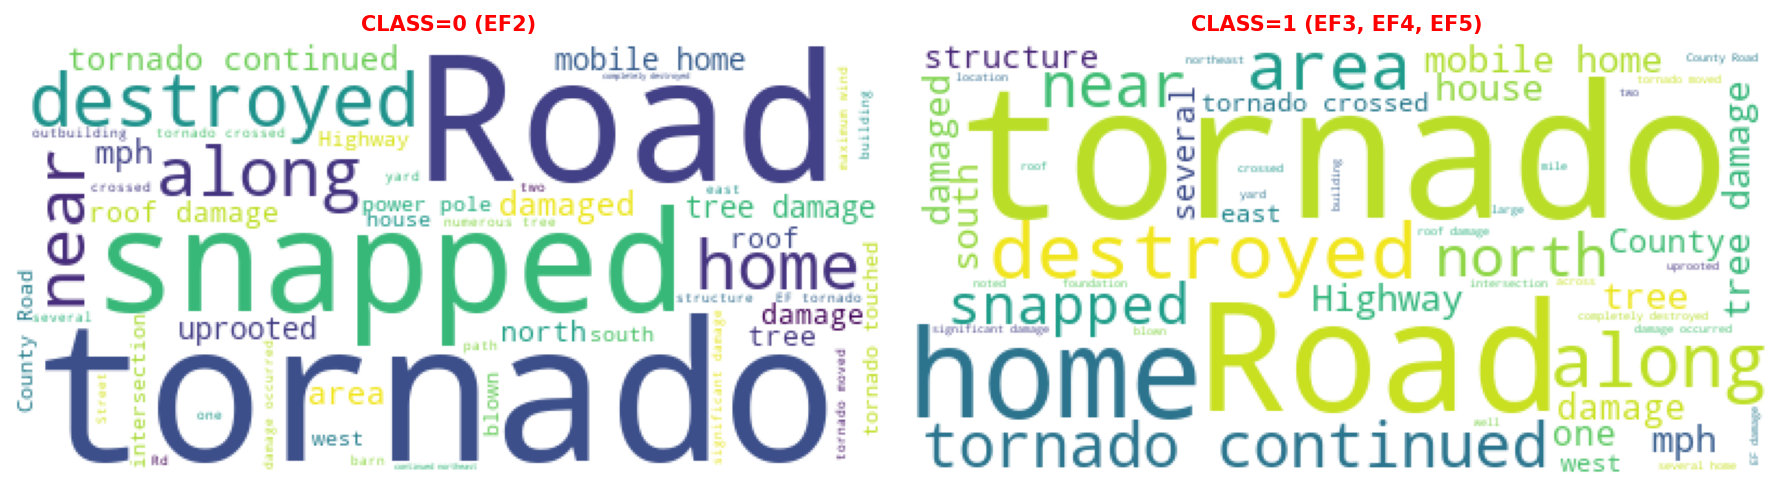

In [6]:

from wordcloud import WordCloud

# Limit to top 50 words for word clouds.
num_words = 50

text0 = df.loc[df["CLASS"]==0, "EVENT_NARRATIVE"].str.cat(sep=" ")
text1 = df.loc[df["CLASS"]==1, "EVENT_NARRATIVE"].str.cat(sep=" ")
wc0 = WordCloud(max_words=num_words, background_color="white").generate(text0)
wc1 = WordCloud(max_words=num_words, background_color="white").generate(text1)

fig, ax = plt.subplots(1, 2, figsize=(12, 12), dpi=150, tight_layout=True)
ax[0].set_title("CLASS=0 (EF2)", fontsize=10, weight="bold", color="red")
ax[0].imshow(wc0)
ax[0].axis("off")
ax[1].set_title("CLASS=1 (EF3, EF4, EF5)", fontsize=10, weight="bold", color="red")
ax[1].imshow(wc1)
ax[1].axis("off")
plt.show()



<br> 

At first glance, the CLASS=0 and CLASS=1 word clouds do not appear meaningfully different.  


<br>


### **2. Using DistilBERT as a Feature Extractor**


Hugging Face is an open-source AI platform best known for making modern NLP and foundation models easy to use and share. It provides pre-trained models, standardized model APIs, and datasets so you don't have to build everything from scratch. Training is more convenient because common tasks—tokenization, batching, fine-tuning, and evaluation—are handled by well-designed libraries with sensible defaults. 

The Python transformers library is Hugging Face's core toolkit for working with models like BERT, GPT, T5, and vision transformers. It offers simple APIs to load pre-trained models, tokenize data and fine-tune on your own datasets. In this section, we carry out the following steps:

0. Create Dataset object from event narratives. 
1. Tokenize event narratives with DistilBERT tokenizer.  
2. Run frozen DistilBERT forward pass.
3. Pool token embeddings into one vector per event.  


Instead of creating a random train-test split, events are split based on time. The training set will include all events from 2008-2022, the test set  2022-present. We do this because language evolves over time and reporting practices change. It can also be viewed as a way to assess how well the model generalizes to future event descriptions. 

In the next cell train and validation Dataset objects are created from the original DataFrame. We create the `DatasetDict` instance manually: Had we opted for a random split, this would have been created automatically when calling `.train_test_split` on the original DataFrame, i.e., `Dataset.from_pandas(df).train_test_split(test_size=0.20)`. Dataset objects integrate tightly with the Transformers training APIs. They represent data in a standard format that supports lazy loading and fast preprocessing. 


In [7]:

from datasets import Dataset, DatasetDict

keep_columns = [
    "EVENT_ID",
    "EVENT_NARRATIVE",
    "TOR_F_SCALE",
    "CLASS"
]

# Create train-test splits. 
dftrain = df[df["YEAR"] <= 2022][keep_columns].reset_index(drop=True)
dfvalid = df[df["YEAR"] >  2022][keep_columns].reset_index(drop=True)

# Create Dataset objects.
ds_train = Dataset.from_pandas(dftrain)
ds_valid = Dataset.from_pandas(dfvalid)
ds = DatasetDict({"train": ds_train, "valid": ds_valid})

# Inspect first training sample.
ds["train"][0]


{'EVENT_ID': 105611,
 'EVENT_NARRATIVE': 'A tornado damaged numerous trees, including large trees uprooted, blew windows out of a home, destroyed a metal shed, blew two windows and part of a wall out of a metal building, damaged at least three grain bins, destroyed or damaged numerous outbuildings and small sheds, blew down or snapped off at least 15 power poles, bent a metal light pole, tipped one wagon and blew the top off another, blew down a barb wire fence and pushed fence posts almost to the ground, destroyed a hog barn, and flattened corn stubble, before crossing the county line into Lyon County. Contents inside several damaged or destroyed buildings and sheds were also damaged, especially on one farm where damaged buildings housed a farm and trucking business.',
 'TOR_F_SCALE': 'EF2',
 'CLASS': 0}


<br>

Inspecting the output of the first training sample, we see it is nothing more than a dictionary representation of the first row in `dftrain` with column names as keys and values set to the original column values. 


The next step it to tokenize event narratives with the DistilBERT tokenizer. [DistilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert) is a smaller, faster, and lighter version of BERT created using knowledge distillation. Essentially a smaller student model learns to mimic a larger teacher BERT model. It retains most of BERT's language understanding performance while using fewer parameters and requiring less compute. 

There are two variants we can choose from: 

- **distilbert-base-uncased**: Does not make a difference between english and English.
- **distilbert-base-cased**: Does make a difference between english and English.

For the remainder of the post, the focus will be on distilbert-base-uncased, but it is very easy to swap and assess different models when working with the transformers library, in many cases it is as simple as updating the model name.

In [8]:

from transformers import AutoTokenizer, AutoModel

# Model name.
model_name = "distilbert-base-uncased"

# Initialize tokenizer and model.
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Run model on GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Send model to device. 
model.to(device)

# Set model to evaluation mode.
model.eval()

# Print number of parameters in model.
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in {model_name}: {total_params:,}")
print(f"Tokenizer vocab_size: {tokenizer.vocab_size:,}")
print(f"Tokenizer model_max_length (maximum context size): {tokenizer.model_max_length}")


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 979.85it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]    
DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Total parameters in distilbert-base-uncased: 66,362,880
Tokenizer vocab_size: 30,522
Tokenizer model_max_length (maximum context size): 512



<br>

Tokenization bridges the gap between free-form narrative text and the numeric tensors required by transformer models. Transformers do not operate on strings. Instead, they consume token IDs which are integers representing sub-word units from a learned vocabulary. DistilBERT uses a subword tokenizer, meaning words can be split into smaller pieces. This allows the model to handle rare words, misspellings, and morphological variations while keeping the vocabulary size manageable.

The tokenizer also produces an attention mask indicating which positions correspond to real tokens versus padding. This is critical when batching variable-length narratives, because the model needs to ignore padded positions when computing internal representations.

distilbert-base-uncased has a vocabulary of size 30,522 and a maximum context size of 512. The maximum context size means there can be at most 512 tokens (subword pieces, not characters or words) in a single input sequence. If an event narrative is longer than this, it must be truncated or split into chunks before being passed to the model.

The next cell provides an example of how we go from raw text to an encoded sequence of embedding IDs. 



In [9]:


# Stanley Brothers, "The Fields have Turned Brown."
text = "The price I have paid, to live and to learn"

# Encoded text. 
enc_input = tokenizer(text, return_tensors='pt')

print(f"enc_input.input_ids.shape : {enc_input.input_ids.shape}")  # (batch_size, sequence_length)

print(f"enc_input:\n{enc_input}")
      

enc_input.input_ids.shape : torch.Size([1, 13])
enc_input:
{'input_ids': tensor([[ 101, 1996, 3976, 1045, 2031, 3825, 1010, 2000, 2444, 1998, 2000, 4553,
          102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [10]:
len(enc_input["input_ids"][0])

13


`enc_input` is a dict-like object with `input_ids` representing the embedding ids, and `attention_mask` a tensor containing 1s for real tokens and 0s for padding tokens added to reach the desired sequence length.


The complete mapping of words/word parts to tokens can be obtained via `tokenizer.get_vocab()`. For example, we can check which id "learn" maps to:



In [11]:

vocab = tokenizer.get_vocab()

print(f"id for learn: {vocab['learn']}")


id for learn: 4553



Referring back to `enc_input`, we see that 4553 is the id at index 11.

To obtain features from the encoded input, `enc_input` is passed into `model`:


In [12]:

# Obtain text features. 
output = model(**enc_input)

print(f"type(output) : {type(output)}\n")
print(f"output.last_hidden_state.shape : {output.last_hidden_state.size()}")  # (batch_size, sequence_length, hidden_size)
print(f"\noutput.last_hidden_state:\n\n{output.last_hidden_state}")



type(output) : <class 'transformers.modeling_outputs.BaseModelOutput'>

output.last_hidden_state.shape : torch.Size([1, 13, 768])

output.last_hidden_state:

tensor([[[-0.0182,  0.0976, -0.0949,  ...,  0.0370,  0.2696,  0.1983],
         [ 0.2047, -0.0677, -0.3011,  ...,  0.0800,  0.4613, -0.0775],
         [ 0.7276, -0.3357, -0.0353,  ..., -0.0306,  0.2783, -0.2500],
         ...,
         [ 0.4852,  0.1291, -0.0054,  ...,  0.0494,  0.4393,  0.2179],
         [ 0.0979,  0.3544, -0.0155,  ..., -0.0864,  0.0971, -0.4329],
         [ 1.0055,  0.4603, -0.2136,  ..., -0.0508, -0.5924, -0.4584]]],
       grad_fn=<NativeLayerNormBackward0>)


<br>

In Hugging Face's BERT models, `last_hidden_state` is the sequence of contextualized embeddings for every token in the input after the final transformer layer. They represent features that will be used to train our classifier. For our Stanley Brothers excerpt, this has dimension (1, 13, 768) = `(batch_size, sequence_length, hidden_size)`:

- `batch_size`: The number of samples passed into the model.
- `sequence_length`: The number of tokens used to represent `text`.
- `hidden_size`: The dimensionality of each token's final embedding after all transformer layers. Every sub-word token is represented as a 768-dimensional vector.


We wrap `tokenizer` inside a small function rather than calling it inline to ensure that truncation, padding, and maximum length are applied identically across training, validation, and inference. The same function can be reused later when scoring new narratives, which helps to avoid mismatches between training and prediction pipelines:


In [13]:

MAX_LEN = 512

def tokenize(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )




When we pass tokenized text through DistilBERT, the model does not return a single vector for the entire narrative. Instead, as we saw with our excerpt from *The Fields Have Turned Brown*, a vector is returned for each token in the sequence (the dimension of the output was 1 x 13 x 768, not 1 x 768). Conceptually, every token receives its own 768-dimensional embedding that reflects the token itself and surrounding context.

Classical machine learning models expect a fixed-length feature vector per observation. This creates a mismatch: we have many token-level vectors for a single narrative, but we need exactly one vector representing the entire event.

Mean pooling address this issue by averaging the token embeddings across the sequence, resulting in a single 768-dimensional vector per narrative (the desired 1 x 768 representation). The attention mask is used so that padded tokens do not contribute to the average. The result can be interpreted as a global summary of the narrative's semantic content.

Pooling is a necessary step whenever we use a transformer as a frozen feature extractor. Without pooling, there is no straightforward way to pass transformer outputs into a traditional classifier.

This is handled in `mean_pool` below:


In [14]:

@torch.no_grad()
def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).float()
    summed = (last_hidden_state * mask).sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1e-9)
    return summed / counts



<br>

At this stage, we combine everything built so far into a single operation that converts raw narrative text into numeric feature vectors. The `embed_texts` function in the next cell takes a list of narratives, tokenizes them, passes them through DistilBERT, and applies mean pooling to produce one fixed-length embedding per event.

Transformers operate on batches of tokenized text and return high-dimensional tensors, not directly usable feature matrices. Classical machine learning models expect a two-dimensional array where each row corresponds to an observation and each column corresponds to a feature. The embedding step bridges that gap by turning free-form text into a matrix of shape (number_of_events, 768).

Once this step is complete, the narratives will have been transformed into numerical features that can be handled in exactly the same way as any other tabular predictor. This is what makes the overall approach so practical: after embedding, the rest of the workflow is indistinguishable from a standard classification problem.



In [15]:

@torch.no_grad()
def embed_texts(texts, batch_size=32):

    all_vecs = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:(i + batch_size)]
        enc = tokenize(batch)
        enc = {k: v.to(device) for k, v in enc.items()}
        out = model(**enc)
        emb = mean_pool(out.last_hidden_state, enc["attention_mask"])
        all_vecs.append(emb.cpu().numpy())

    return np.vstack(all_vecs)



`embed_texts` is then used to generate features from the training and validation sets. The next cell may take 5-10 minutes to run if using CPU:

In [16]:

X_train = embed_texts(ds["train"]["EVENT_NARRATIVE"], batch_size=32)
X_valid = embed_texts(ds["valid"]["EVENT_NARRATIVE"], batch_size=32)
y_train = np.array(ds["train"]["CLASS"])
y_valid = np.array(ds["valid"]["CLASS"])

print(f"X_train shape: {X_train.shape}; y_train.shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}; y_valid.shape: {y_valid.shape}")


X_train shape: (2620, 768); y_train.shape: (2620,)
X_valid shape: (641, 768); y_valid.shape: (641,)



<br>


### **3.  Classification**

At this point, we can use all the familiar scikit-learn tooling to fit a classifier, because the problem has been fully reduced to standard tabular modeling. Each tornado event is now represented by a fixed-length numeric vector, and the target is a simple binary label indicating EF2 versus EF3+.

When working with transformer embeddings, simple linear models often perform surprisingly well, since much of the complexity has already been absorbed by the language model. Logistic Regression is a natural first choice in this setting. It is fast to train, handles high-dimensional feature spaces well, and provides well-behaved probability estimates. The embeddings produced by DistilBERT have 768 dimensions, which makes the problem inherently high-dimensional. Linear models with regularization are well-suited to this regime, because regularization helps control overfitting by shrinking less informative coefficients toward zero.

Nothing about this step is specific to text anymore. We could swap Logistic Regression for a Random Forest, Gradient Boosting model, or any other scikit-learn classifier without changing the upstream pipeline. This separation between representation learning and downstream modeling is one of the major advantages of using pretrained transformers as feature extractors.

In the next cell, we fit a Logistic Regression model with Elastic Net penalty. A grid search is performed over `l1_ratio` and `C` to identify the regularization regime which maximizes f1-score. 

In [19]:

from scipy.stats import uniform, loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

random_state = 516
verbosity = 3
n_iter = 50
scoring = "recall"
cv = 3

param_grid = {
    "l1_ratio": uniform(loc=0, scale=1), 
    "C": loguniform(1e-4, 1e4)
    }

clf = RandomizedSearchCV(
    LogisticRegression(solver="saga", class_weight="balanced", max_iter=500), 
    param_grid, 
    scoring=scoring, 
    cv=cv, 
    verbose=verbosity, 
    random_state=random_state, 
    n_iter=n_iter,
    n_jobs=-1
)

clf.fit(X_train, y_train)

print(f"\nOptimal parameters: {clf.best_params_}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits

Optimal parameters: {'C': 0.10443596935926203, 'l1_ratio': 0.4360994501308848}



<br>

Assess model performance on holdout data:

In [20]:

from sklearn.metrics import classification_report

print(classification_report(y_valid, clf.predict(X_valid), digits=5))


              precision    recall  f1-score   support

           0    0.89447   0.71919   0.79731       495
           1    0.42798   0.71233   0.53470       146

    accuracy                        0.71763       641
   macro avg    0.66123   0.71576   0.66601       641
weighted avg    0.78822   0.71763   0.73750       641




This is a very solid result, given that we used a frozen encoder and text-only features. In particular, what matters most for our use case is CLASS=1 recall = 0.71, which means roughly 7 out of every 10 truly severe tornadoes are being correctly identified. Precision = 0.43, so only about half of the tornadoes flagged as EF3+ truly are EF3+. This is the expected tradeoff: recall increased, and we paid for it with more false positives.


### **Conclusion**

The big-picture interpretation is that the pipeline works and the model has learned meaningful signal from the text on a real-world dataset.
It's worth emphasizing that the goal of this post was not to squeeze out the last basis point of classification performance, but to build intuition around how a pretrained transformer like DistilBERT can be used as a general-purpose feature extractor for downstream modeling. Even with a relatively simple Logistic Regression head, we were able to convert unstructured event narratives into dense numerical representations with only a few lines of code and obtain better than expected results. There are many obvious avenues for improvement:

- Experiment with alternative pooling strategies.
- Trying different pretrained backbones.
- Moving beyond linear models to more expressive classifiers. 
- Incorporating additional features (property damage, spatial variables, etc.)

These are left as exercises for the reader. 

In Part 2, we'll take the next step and fine-tune the transformer itself for the same task, allowing the language model to adapt its internal representations directly to the classification objective, and demonstrate why end-to-end fine-tuning often delivers significant performance improvement over fixed embeddings.


